# DIVAnd analysis using the sample data set

* First follow the installation instruction at https://gher-ulg.github.io/Diva-Workshops/installation.html
* This example makes a salinity analysis using data from the Black Sea
* The analysis is done for every season and year (using all data with 10-year sliding windows form the same season) 

Load the modules

In [7]:
using divand
using PyPlot
using NCDatasets
using DataStructures

# Load a more efficient version of sparse matrix multiplication
include(joinpath(Pkg.dir("divand"),"src","override_ssmult.jl"))

Download the file `Salinity.bigfile` (if it is not already present). It will be placed in the same directory as this notebook. This file based on the World Ocean Database.

In [8]:
fname = "Salinity.bigfile"

if !isfile(fname)
    download("https://b2drop.eudat.eu/s/Bv9Fj0YGC0zp2vn/download",fname)
else
    info("Data file already downloaded")
end

INFO: Data file already downloaded


Download the bathymetry if it is not already present

In [9]:
bathname = "gebco_30sec_16.nc"

if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/o0vinoQutAC7eb0/download",bathname)
else
    info("Bathymetry file already downloaded")
end

bathisglobal = true

INFO: Bathymetry file already downloaded


true

Load the data which is here a simple text file with the following columns

| longitude | latitude | value | depth | flag | year | month | day | hour | time string | identifier | bottom depth |
|----------:|---------:|------:|------:|-------:|------:|-----:|-----|------:|-------:|-------:|-------:|
| 28.3333 | 43.167 | 15.7020 | 0.0 | 0 | 1991 | 09 | 03 | 16 | 1991-09-03T16:25 | Cruise:WOD05_BG000003-11570900-28.3333-43.167 | 36 | 
| 28.3333 | 43.167 | 15.7380 | 10.0 | 0 | 1991 | 09 | 03 | 16 | 1991-09-03T16:25 | Cruise:WOD05_BG000003-11570900-28.3333-43.167 | 36 |

Only longitude, latitude, depth, time and the values are used.

In [10]:
value,lon,lat,depth,time,ids = loadbigfile(fname);
@show size(value)

size(value) = (139230,)


(139230,)

The file contains about 140000 measurements.     
Print some basic statistics about the data. Keep an eye on the ranges.

In [11]:
checkobs((lon,lat,depth,time),value,ids)

              minimum and maximum of obs. dimension 1: (27.1005, 41.65)
              minimum and maximum of obs. dimension 2: (40.517, 47.272)
              minimum and maximum of obs. dimension 3: (0.0, 2000.0)
              minimum and maximum of obs. dimension 4: (1977-03-27T04:00:00, 2006-12-15T09:52:00)
                          minimum and maximum of data: (0.0, 38.6573)


Define the resolution. It is recommended to start with a low resolution and increase the resolution when the results are suitable.

In [12]:
dx = 0.2 # longitude resolution in degrees
dy = 0.2 # latitude resolution in degrees

0.2

Define bounding box spatial domain

In [13]:
lonr = 27.:dx:42.; # the range of longitudes (start:step:end)
latr = 40.:dy:47.; # the range of latitudes (start:step:end)

Define the depth levels

In [14]:
depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000]


# or for testing just a few levels
depthr = [0.,20.,50.]

@show size(depthr);

size(depthr) = (3,)


The error variance of the observation (scaled by the error variance of the background).    
Note that this is the inverse of the signal-to-noise ratio used in the 2D version of `DIVA`.

In [15]:
epsilon2 = 0.01

0.01

* Correlation length in meters (in x, y, and z directions)
* 200_000. is the same as 200000., but the former is easier to read

In [16]:
sz = (length(lonr),length(latr),length(depthr))

lenx = fill(200_000.,sz)
leny = fill(200_000.,sz)
lenz = [10+depthr[k]/15 for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]];

Year range and averaging time window

In [17]:
years = 1993:1994

year_window = 10

# winter: January-March    1,2,3
# spring: April-June       4,5,6
# summer: July-September   7,8,9
# autumn: October-December 10,11,12

monthlists = [
    [1,2,3],
    [4,5,6],
    [7,8,9],
    [10,11,12]
];

* Other possible choises for the time selector are `TimeSelectorYearListMonthList` and `TimeSelectorRunningAverage`.
* Type `?` followed by these functions

In [18]:
?TimeSelectorYW

search: TimeSelectorYW TimeSelectorYearListMonthList TimeSelectorRunningAverage



```
TS = TimeSelectorYW(years,yearwindow,monthlists)
```

The structure `TS` handels the time arregation base on `years` and  `monthlists`. It is similar to `TimeSelectorYearListMonthList` except that  the elements of `yearlists` are centred around `years` and span  `yearwindow` years. `yearlists` is in fact constructed by additing and subtract  `yearwindow/2` to every  element of years.


In [19]:
TS = TimeSelectorYW(years,year_window,monthlists)

varname = "Salinity"

# File name based on the variable (but all spaces are replaced by _)
filename = "Water_body_$(replace(varname,' ','_')).4Danl.nc"

# Time origin for the NetCDF file
timeorigin = DateTime(1900,1,1,0,0,0)

# Extract the bathymetry for plotting
bx,by,b = extract_bath(bathname,bathisglobal,lonr,latr);

A list of all metadata

In [17]:
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-Chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    "production" => "Diva group. E-mails: a.barth@ulg.ac.be, swatelet@ulg.ac.be",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet/EMODNet Chemistry Data Network",

    # Additional comment
    "comment" => "...",

    # SeaDataNet Vocabulary P35 URN
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    # example: SDN:P35::WATERTEMP
    "parameter_keyword_urn" => "SDN:P35::EPC00001",

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    # example: ["SDN:P02::TEMP"]
    "search_keywords_urn" => ["SDN:P02::PSAL"],

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    # example: ["SDN:C19::3_1"]
    "area_keywords_urn" => ["SDN:C19::3_3"],

    "product_version" => "1.0",

    # NetCDF CF standard name
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    # example "standard_name" = "sea_water_temperature",
    "netcdf_standard_name" => "sea_water_salinity",

    "netcdf_long_name" => "sea water salinity",

    "netcdf_units" => "1e-3",

    # Abstract for the product
    "abstract" => "...",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgment" => "...",

    # Digital Object Identifier of the data product
    "doi" => "...")

DataStructures.OrderedDict{String,Any} with 16 entries:
  "project"               => "SeaDataCloud"
  "institution_urn"       => "SDN:EDMO::1579"
  "production"            => "Diva group. E-mails: a.barth@ulg.ac.be, swatelet@…
  "Author_e-mail"         => String["Your Name1 <name1@example.com>", "Other Na…
  "source"                => "observational data from SeaDataNet/EMODNet Chemis…
  "comment"               => "..."
  "parameter_keyword_urn" => "SDN:P35::EPC00001"
  "search_keywords_urn"   => String["SDN:P02::PSAL"]
  "area_keywords_urn"     => String["SDN:C19::3_3"]
  "product_version"       => "1.0"
  "netcdf_standard_name"  => "sea_water_salinity"
  "netcdf_long_name"      => "sea water salinity"
  "netcdf_units"          => "1e-3"
  "abstract"              => "..."
  "acknowledgment"        => "..."
  "doi"                   => "..."

* Make the NetCDF global and variable attributes based on the metadata.
* Custom attributes can be added by changing `ncglobalattrib`:

```julia
ncglobalattrib["attribute_name"] = "attribute_value"
```


In [18]:
ncglobalattrib,ncvarattrib = SDNMetadata(metadata,filename,varname,lonr,latr)

(DataStructures.OrderedDict("project"=>"SeaDataCloud","institution"=>"University of Liege, GeoHydrodynamics and Environment Research","institution_urn"=>"SDN:EDMO::1579","production"=>"Diva group. E-mails: a.barth@ulg.ac.be, swatelet@ulg.ac.be","Author_e-mail"=>"Your Name1 <name1@example.com>, Other Name <name2@example.com>","source"=>"observational data from SeaDataNet/EMODNet Chemistry Data Network","comment"=>"...","parameter_keyword"=>"Water body salinity","parameter_keyword_urn"=>"SDN:P35::EPC00001","search_keywords"=>"Salinity of the water column"…), DataStructures.OrderedDict("units"=>"1e-3","standard_name"=>"sea_water_salinity","long_name"=>"sea water salinity"))

Plot the results the surface for debugging and quick inspection.

To generate the plots, we define a function `plotres` (see next cell) that will be used as an optional argument when we call the interpolation with `DIVAnd`.

In [20]:
function plotres(timeindex,sel,fit,erri)
    tmp = copy(fit)
    tmp[erri .> .5] = NaN;
    figure()
    subplot(2,1,1)
    title("$(timeindex) - surface")
    
    # select the data near the surface
    selsurface = sel .& (depth .< 5)
    vmin = minimum(value[selsurface])
    vmax = maximum(value[selsurface])
    
    # plot the data
    scatter(lon[selsurface],lat[selsurface],10,value[selsurface];
            vmin = vmin, vmax = vmax)
    xlim(minimum(lonr),maximum(lonr))
    ylim(minimum(latr),maximum(latr))
    colorbar()
    contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
    
    # plot the analysis
    subplot(2,1,2)
    pcolor(lonr,latr,tmp[:,:,1]';
           vmin = vmin, vmax = vmax)
    colorbar()
    contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
end

plotres (generic function with 1 method)

Launch the analysis. Plotting can be disabled by commenting the line containing `plotres`.

Here we use `diva3d`, which performs a series of 3D analyses (lon, lat and depth) for the different periods defined previously.

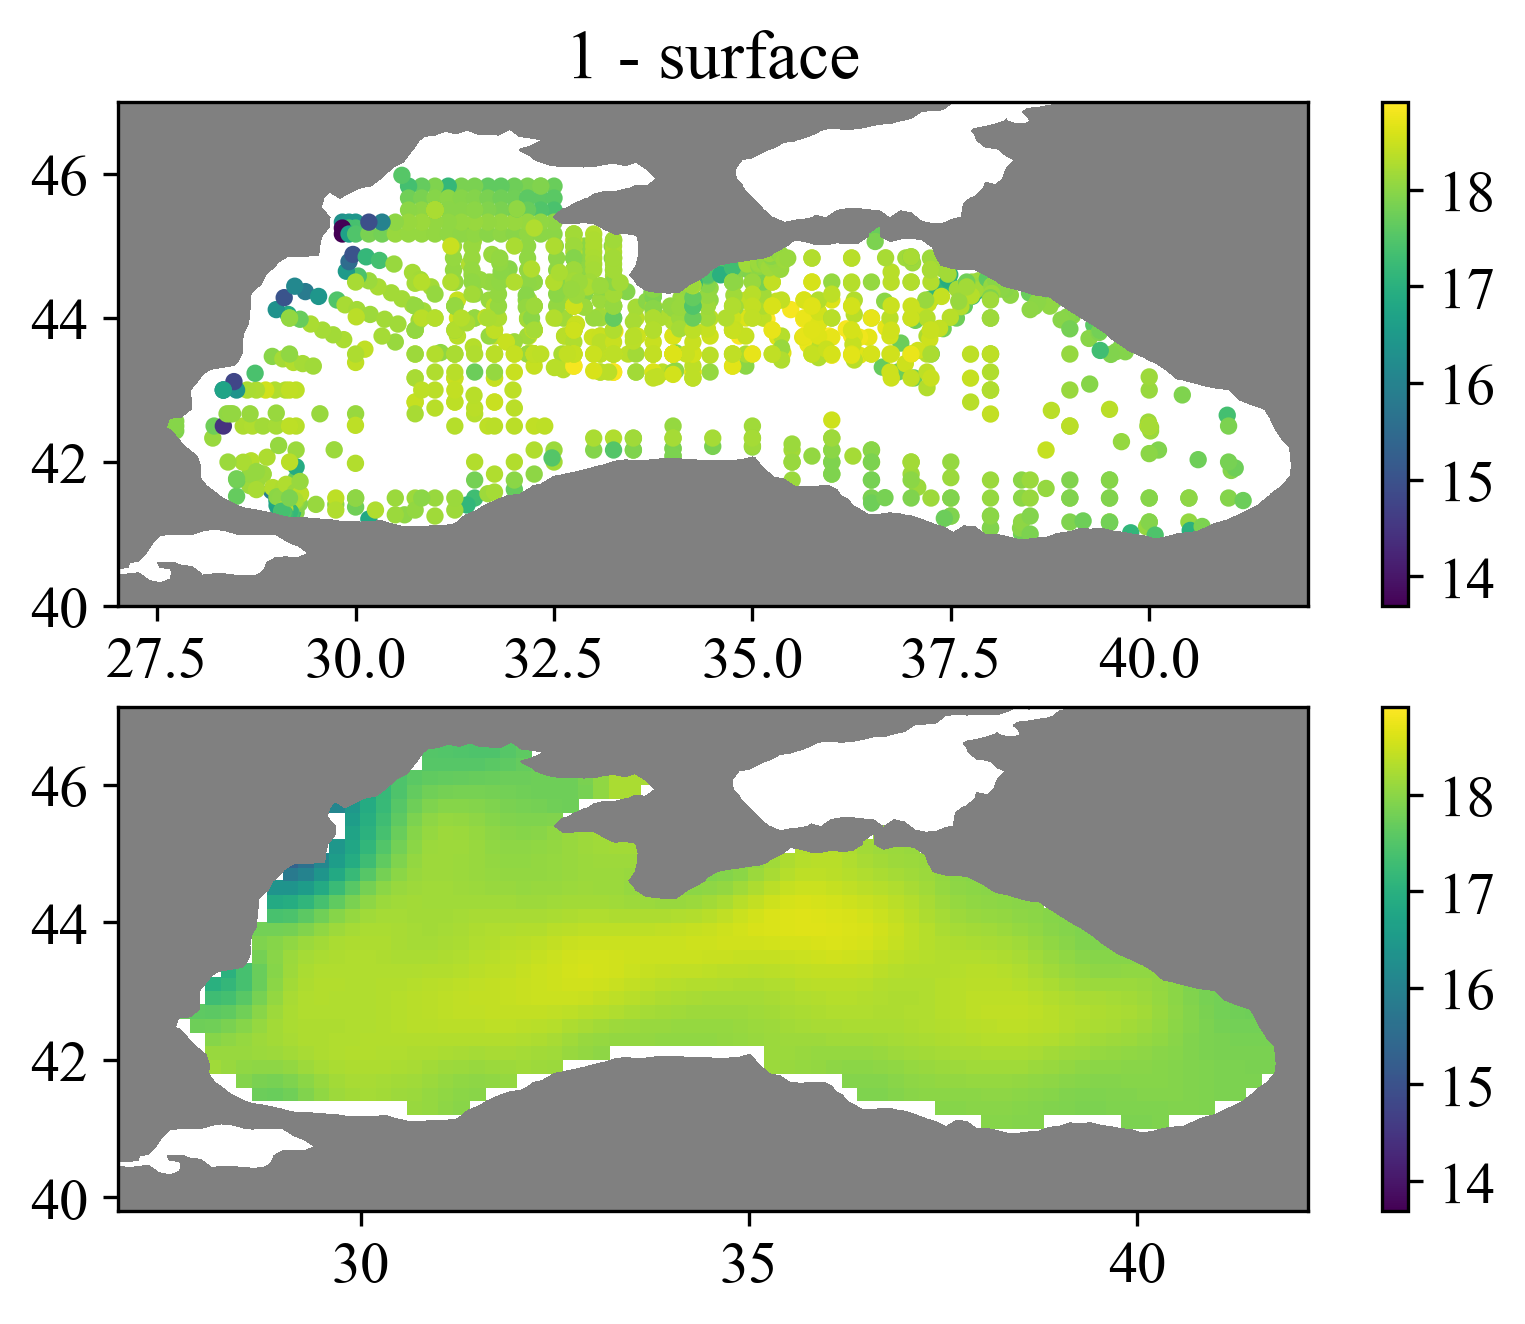

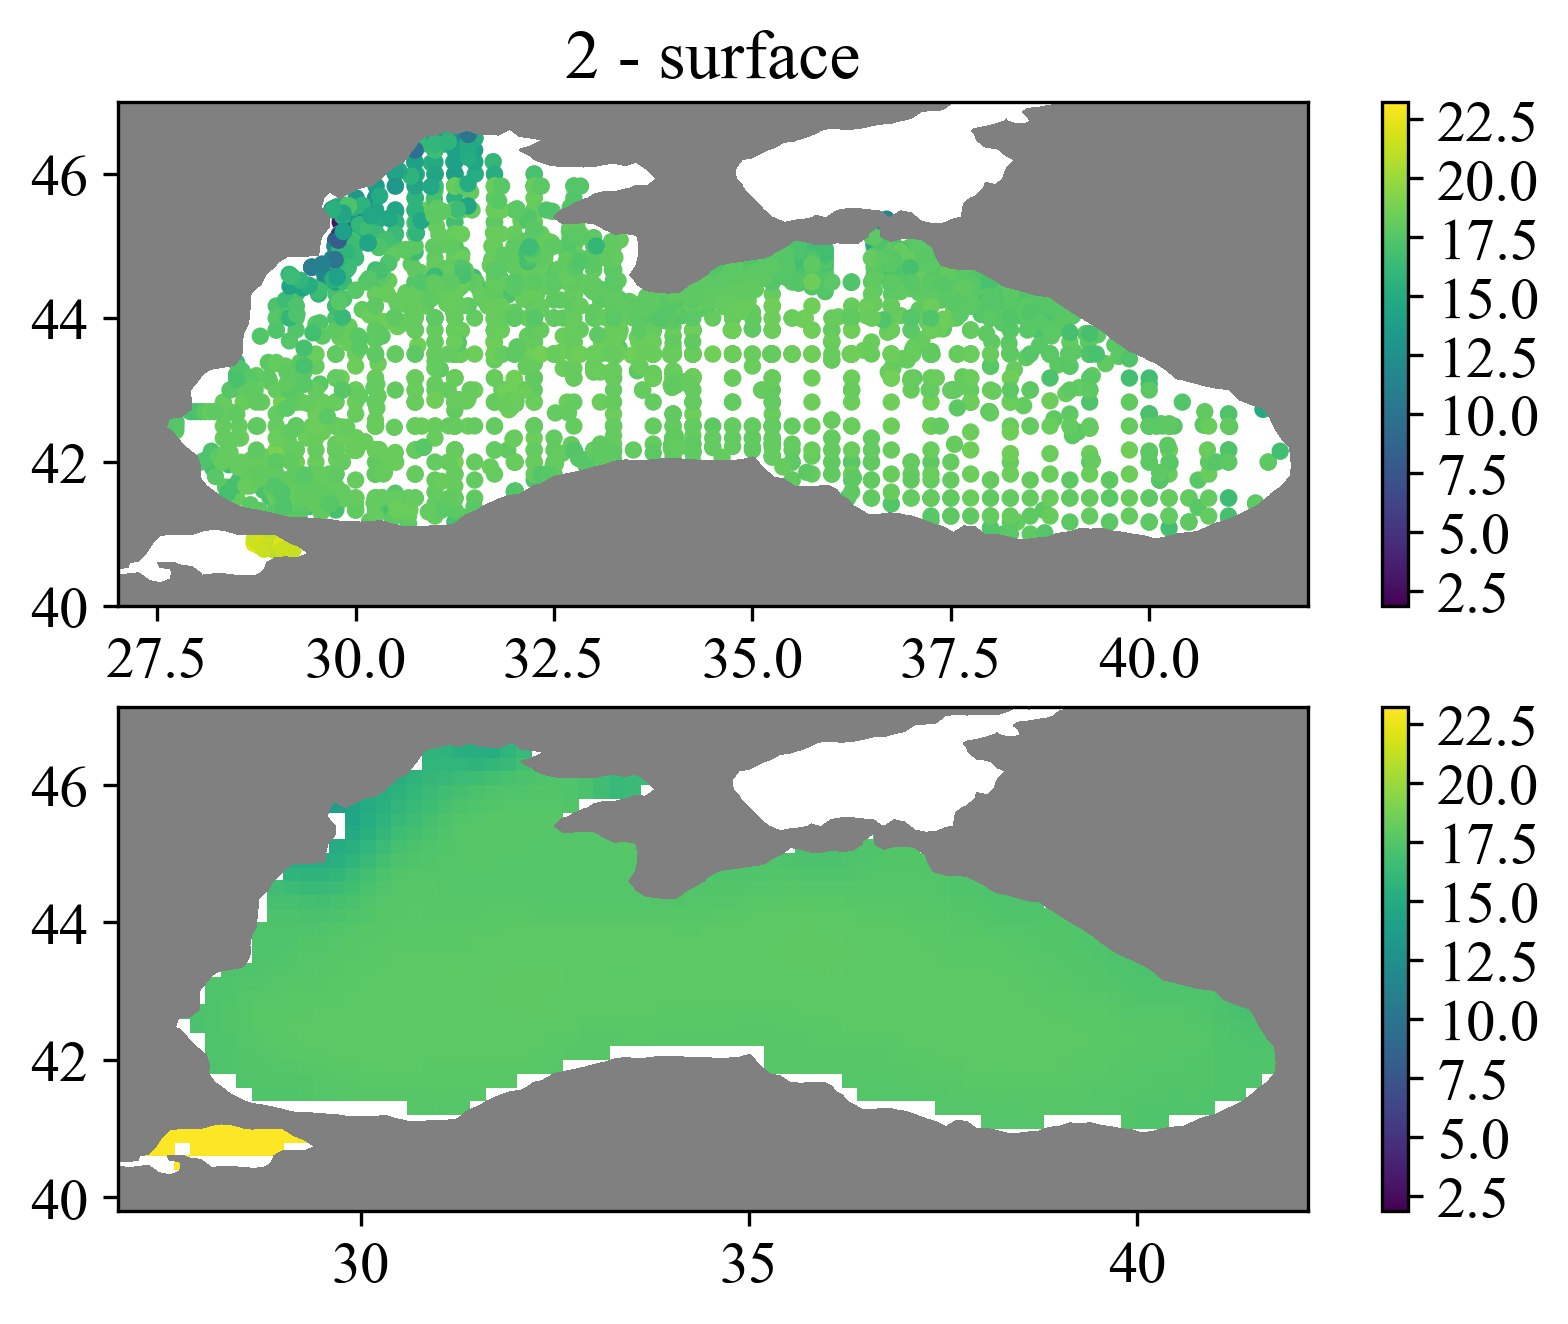

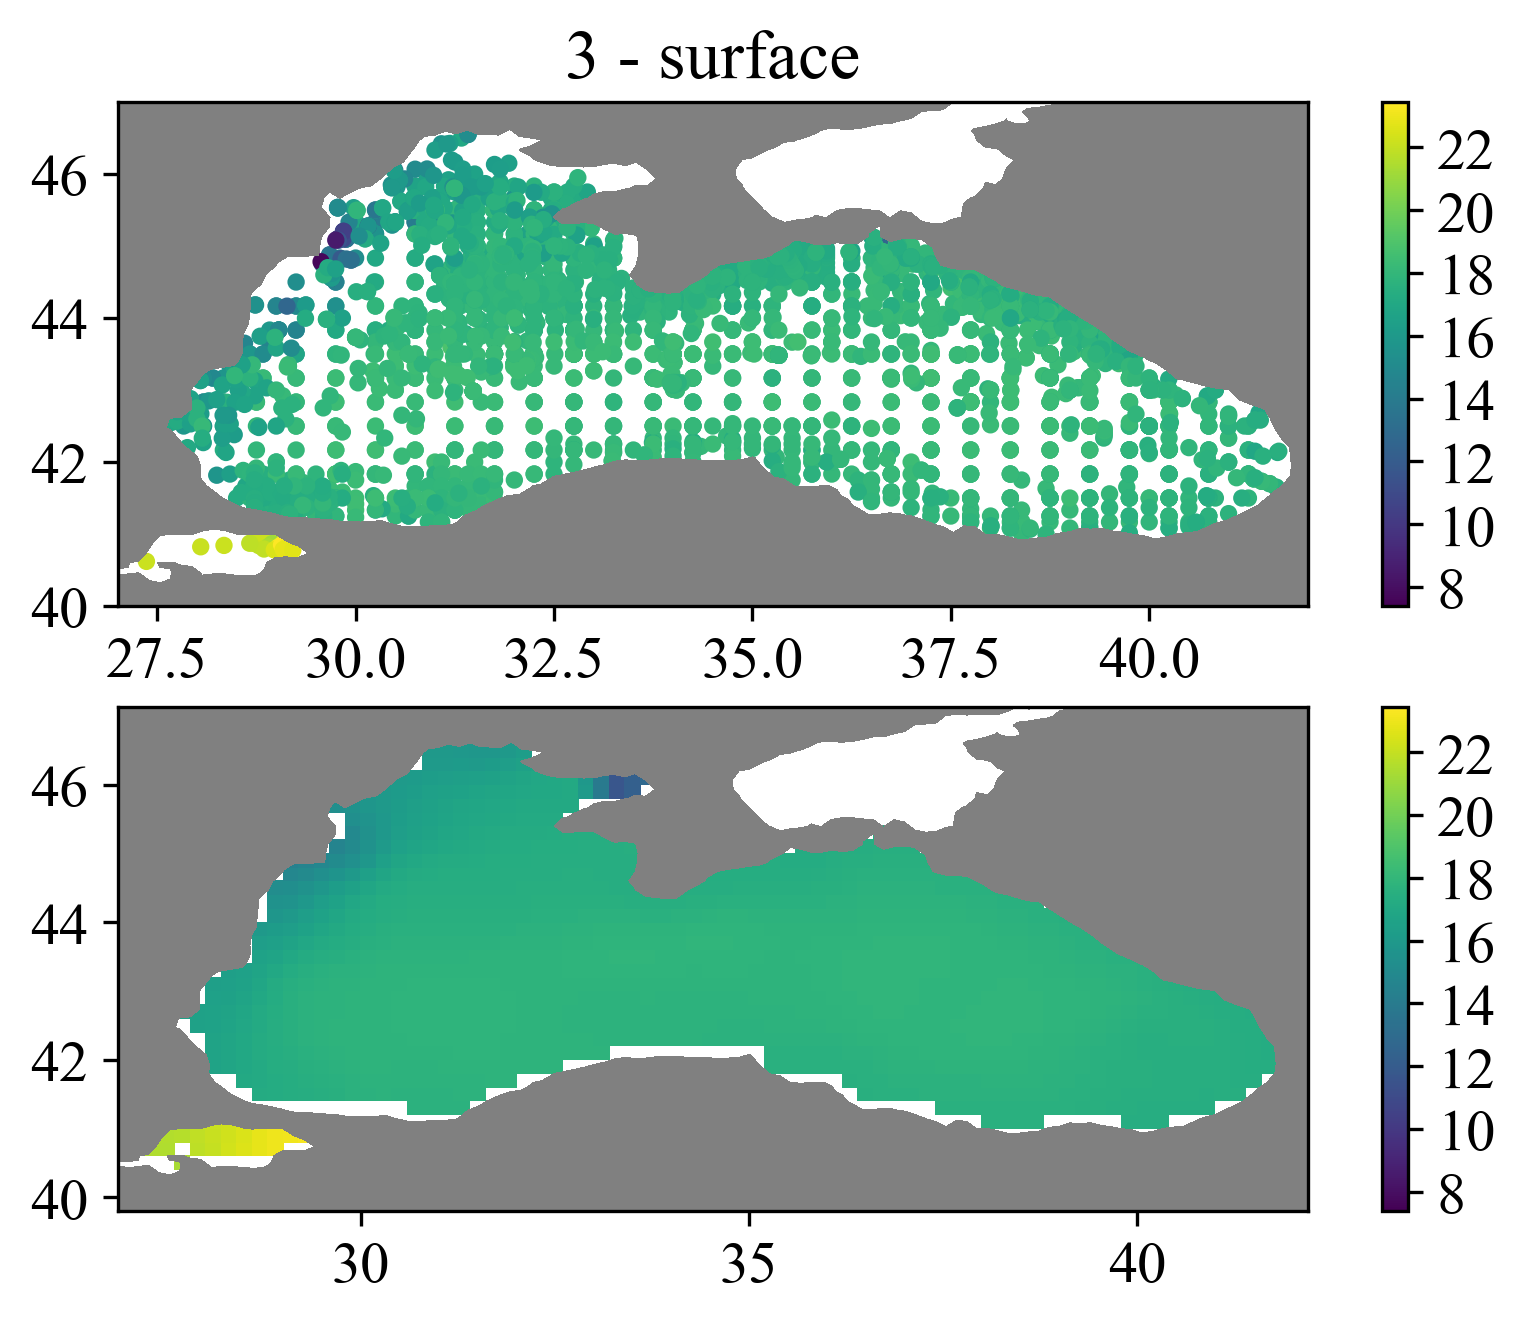

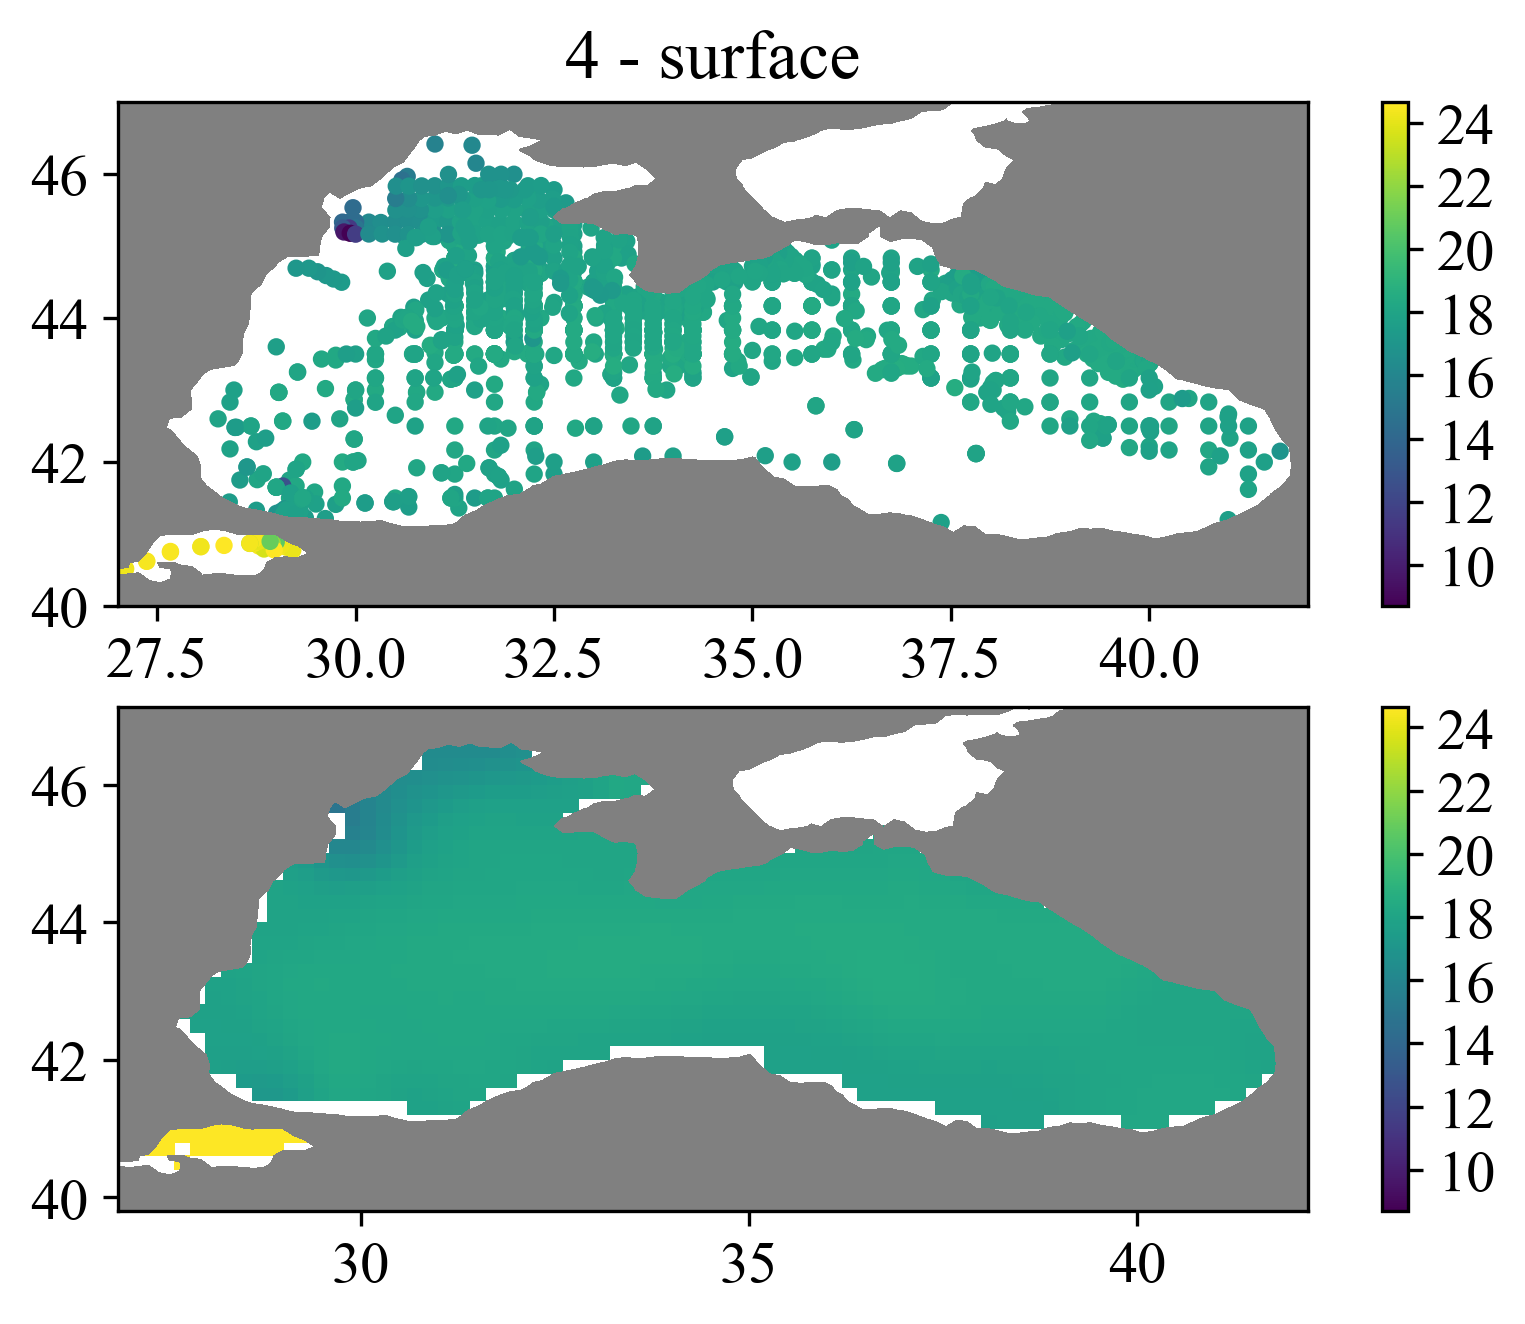

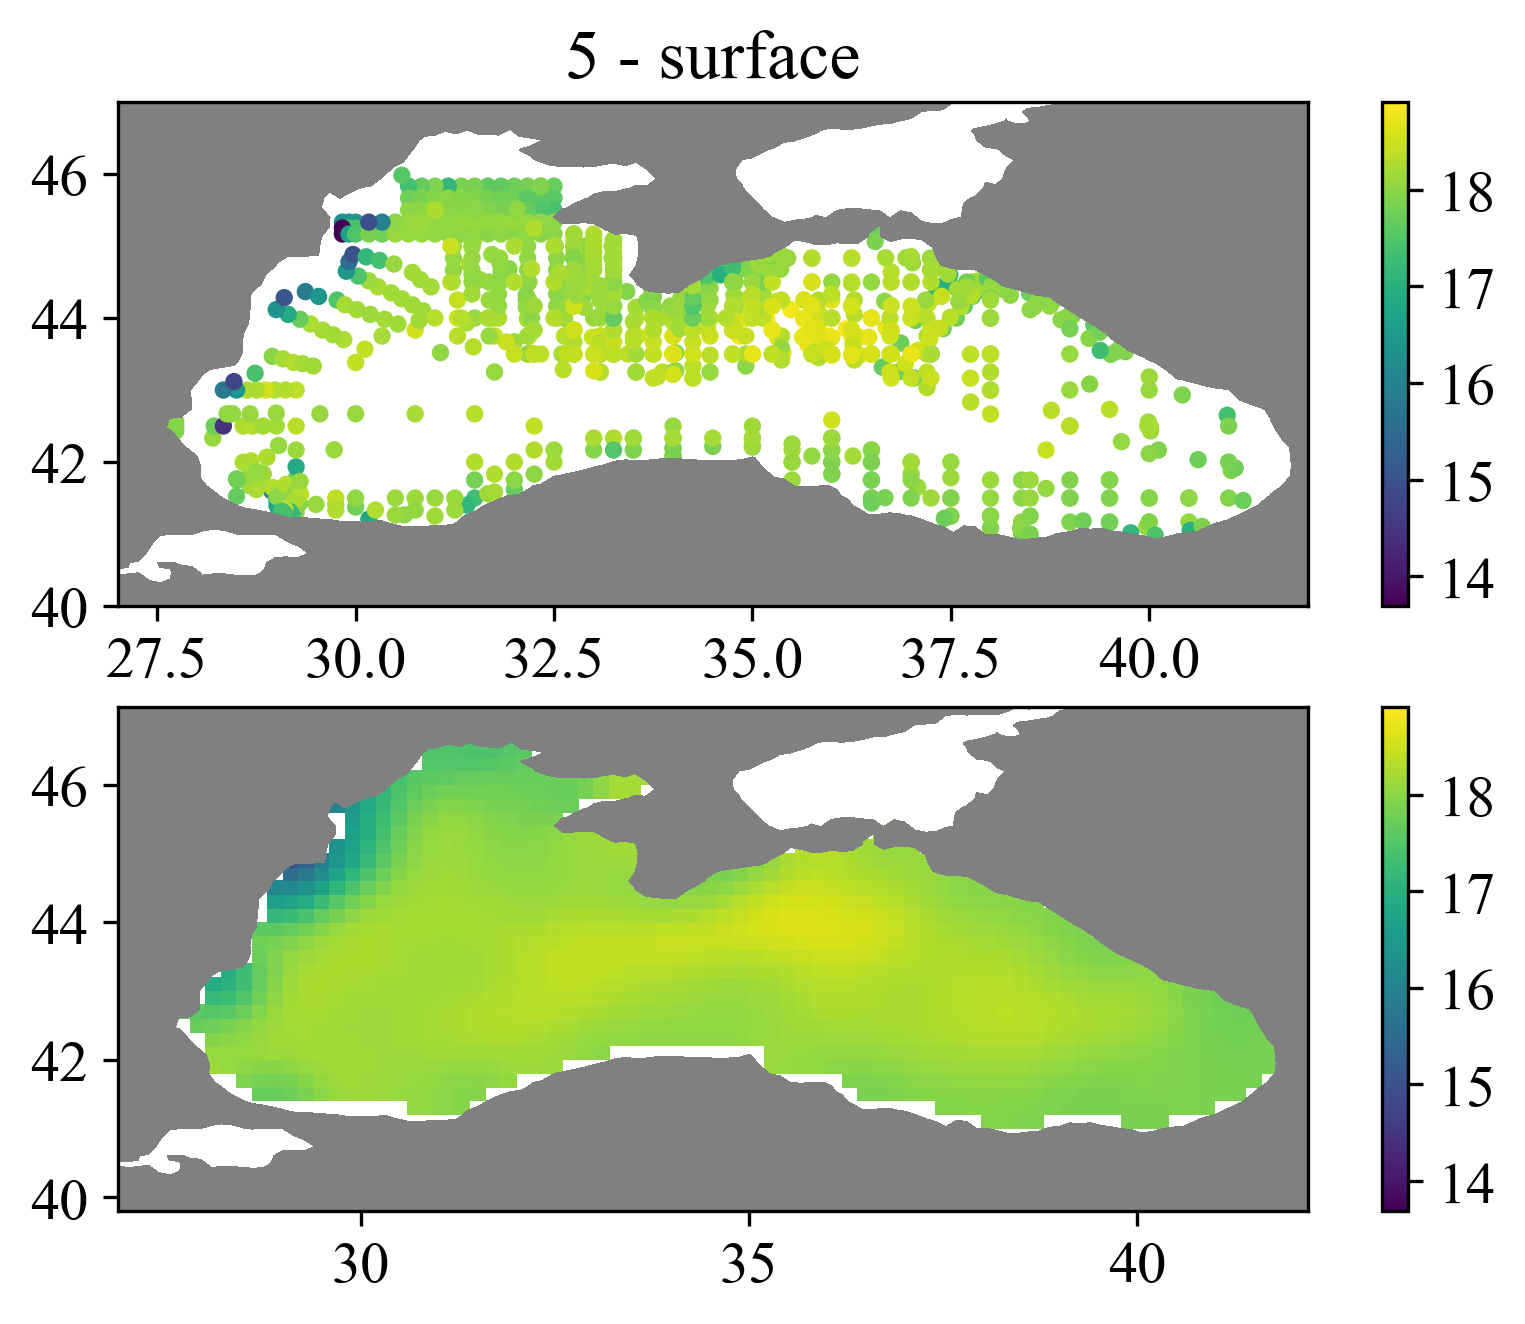

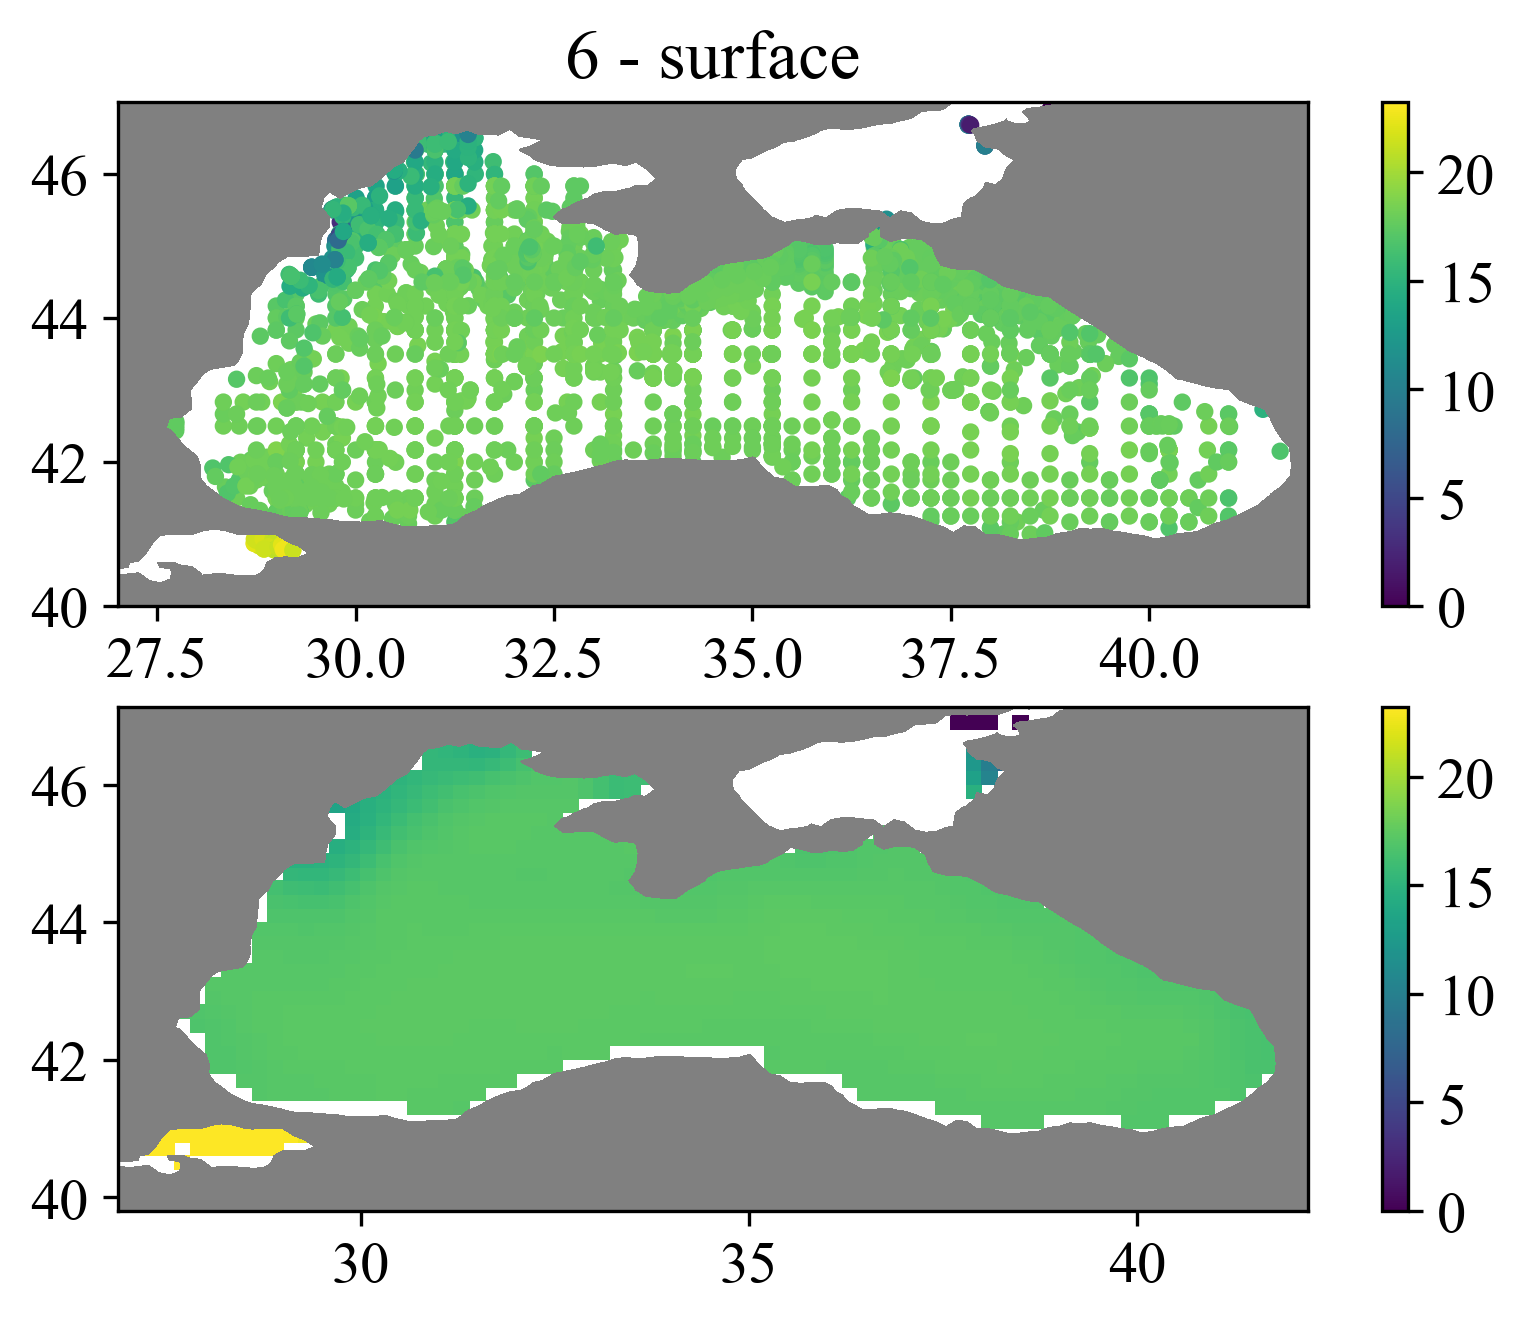

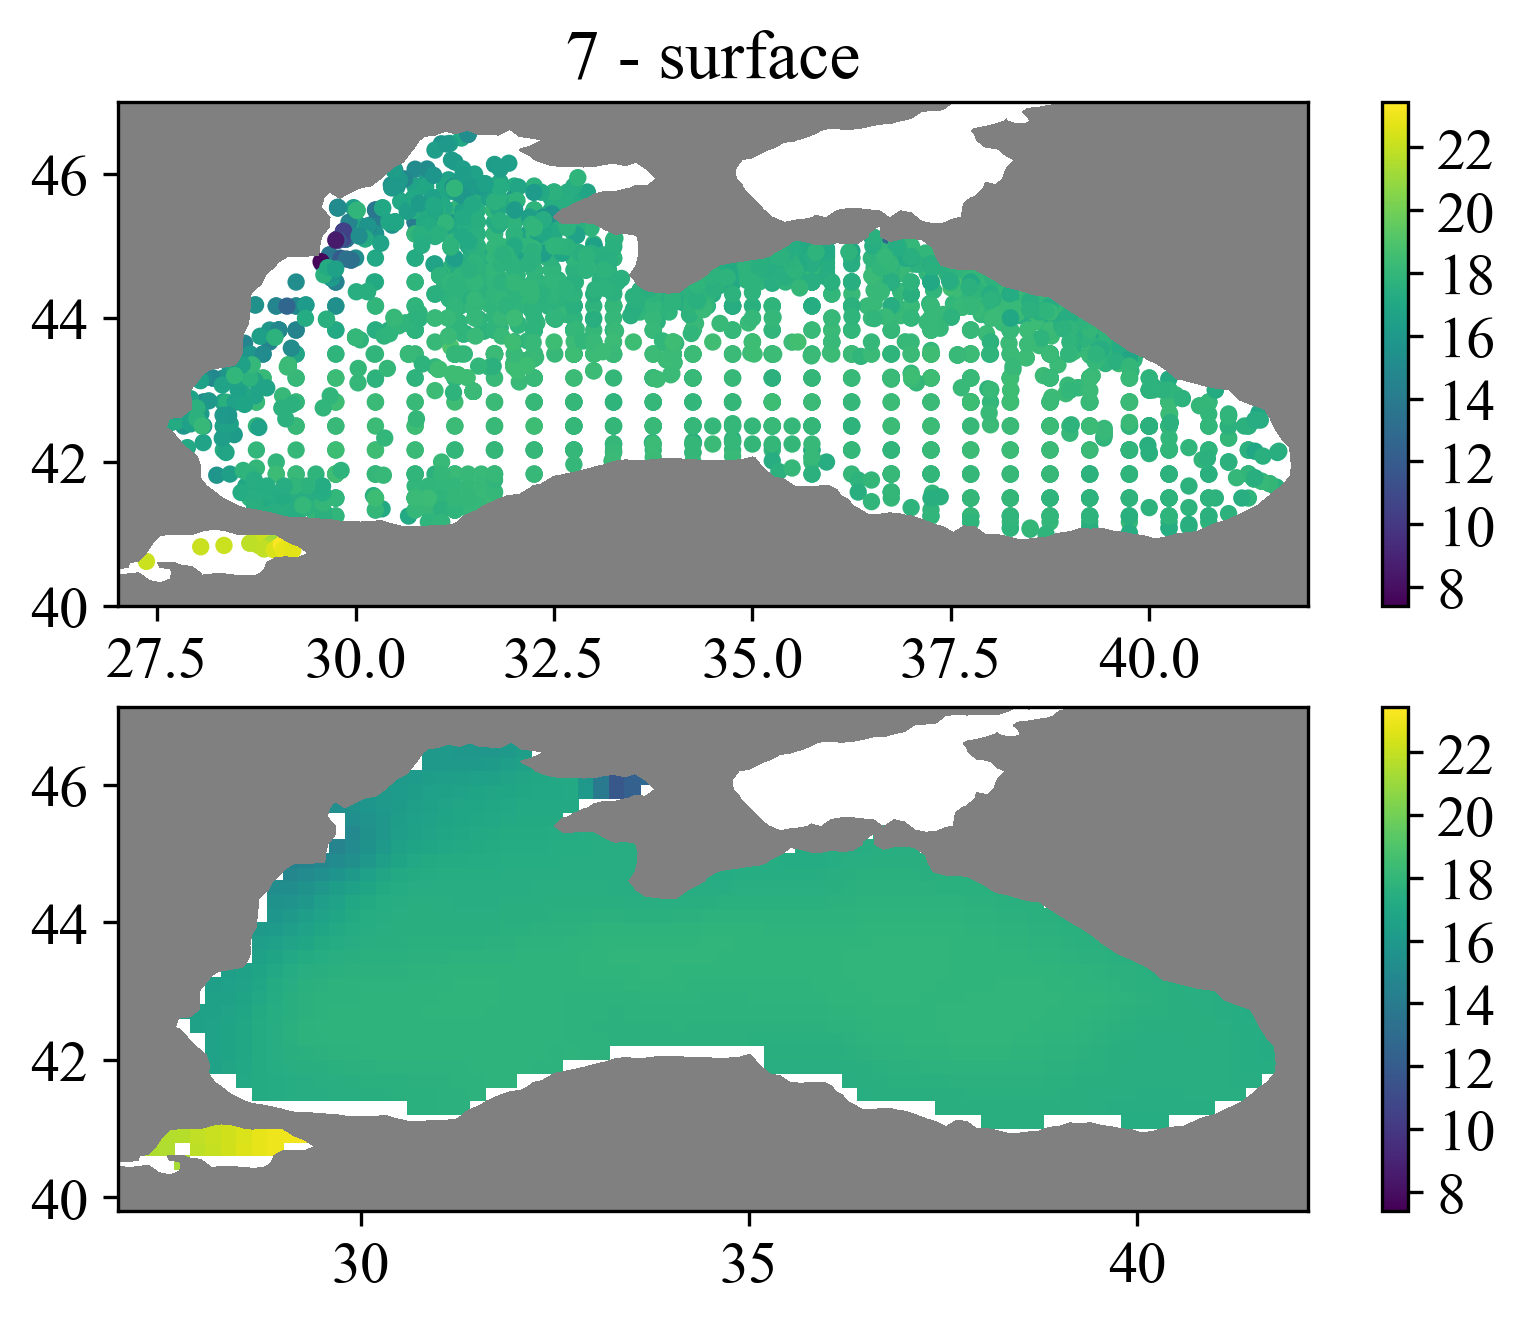

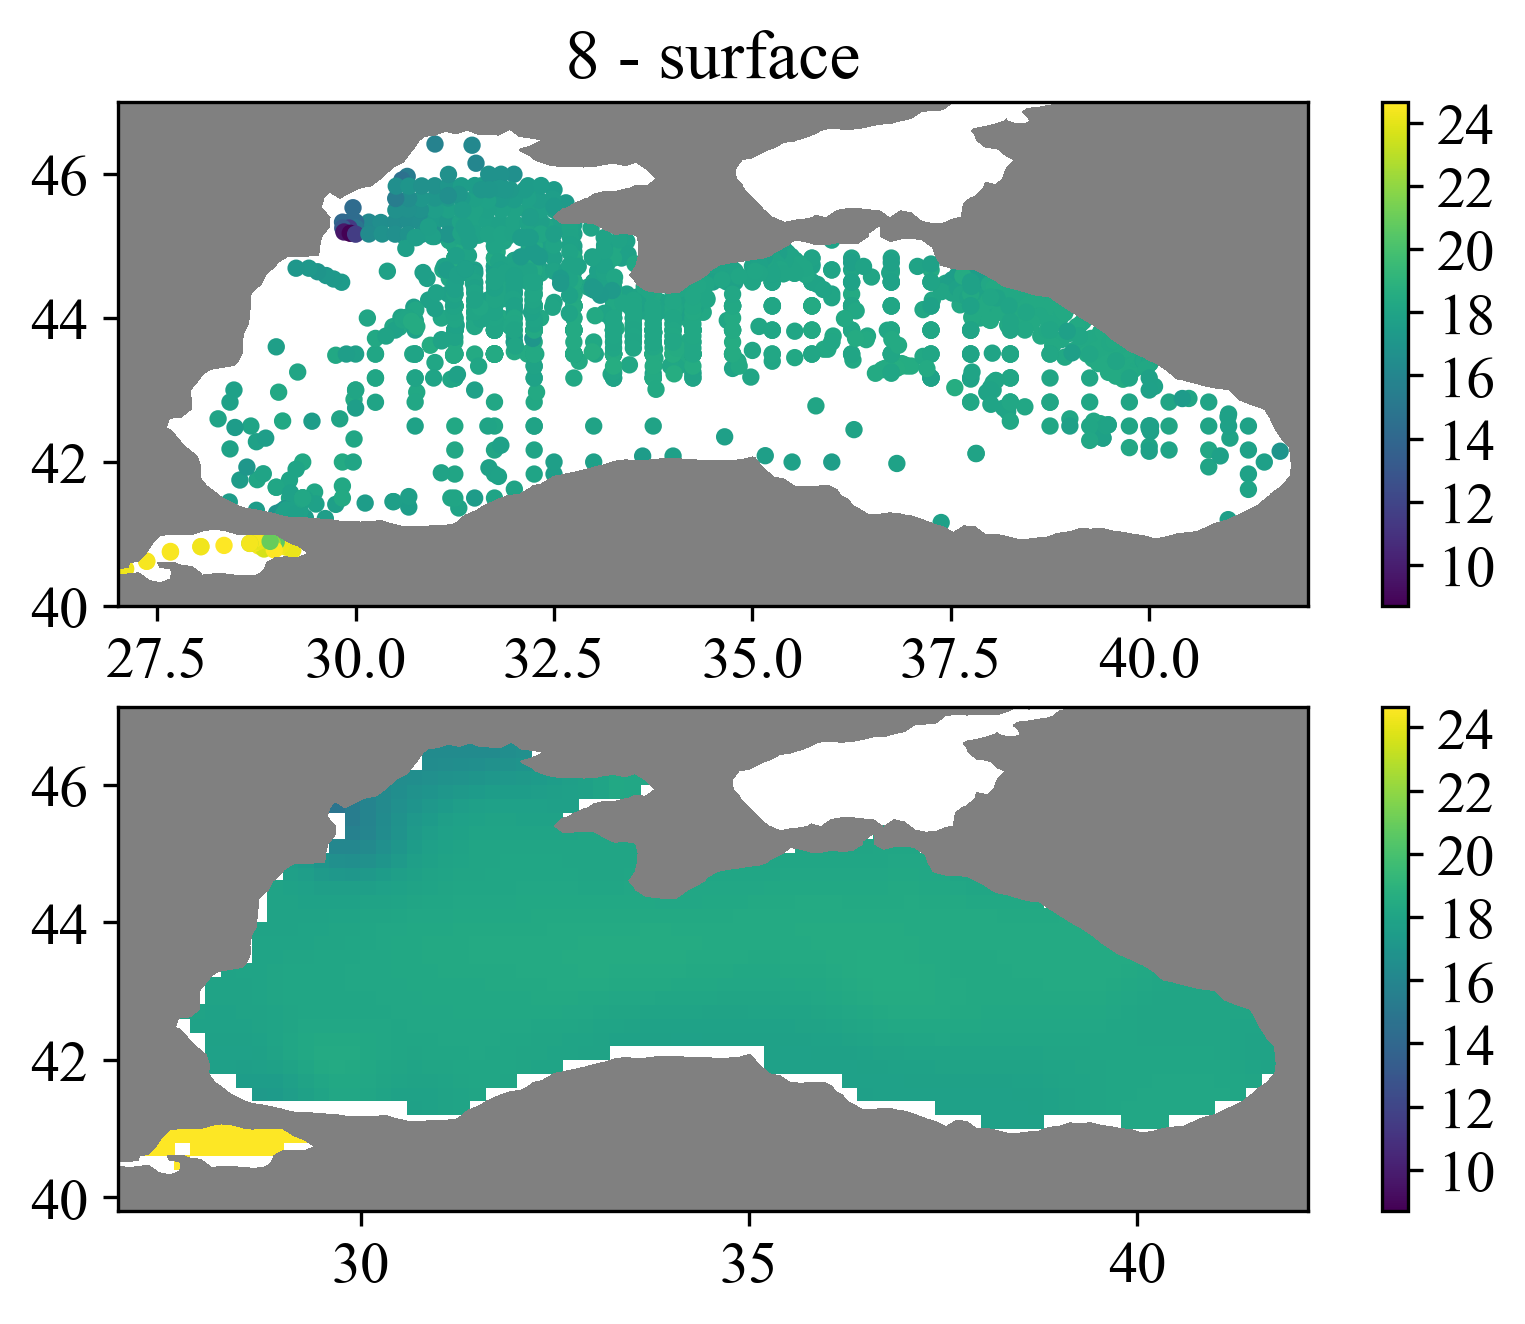

In [21]:
if isfile(filename)
   rm(filename) # delete the previous analysis
end

diva3d((lonr,latr,depthr,TS),
              (lon,lat,depth,time),
              value,epsilon2,
              (lenx,leny,lenz),
              filename,varname,
              bathname = bathname,
              bathisglobal = bathisglobal,
              plotres = plotres,
              ncvarattrib = ncvarattrib,
              ncglobalattrib = ncglobalattrib,
              timeorigin = timeorigin
       )

This generates many plots (one for every time instance). The number in the title is the time index starting with the first season and year.


## XML metadata

* For DIVAnd analysis using SeaDataCloud/EMODNET-Chemistry data, one can create a XML description for the product for Sextant

Name of the project ("SeaDataCloud" or "EMODNET-chemistry")

In [1]:
project = "SeaDataCloud"

"SeaDataCloud"

Download CDI list

In [2]:
cdilist = "CDI-list-export.zip"

if !isfile(cdilist)
   download("http://emodnet-chemistry.maris2.nl/download/export.zip",cdilist)
end

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9623k  100 9623k    0     0   741k      0  0:00:12  0:00:12 --:--:--  152k


"CDI-list-export.zip"

If `ignore_errors` is `false` (default), then a missing CDI will stop the creatation of the XML metadata.

In [20]:
ignore_errors = true

# File name based on the variable (but all spaces are replaced by _)
xmlfilename = "Water_body_$(replace(varname,' ','_')).4Danl.xml"

"Water_body_Salinity.4Danl.xml"

Uncomment the following line of you are using SeaDataClour or EMODNET-Chemistry data

In [21]:
# generate a XML file for Sextant (only for )
#divadoxml(filename,varname,project,cdilist,xmlfilename,
#          ignore_errors = ignore_errors)